# Data prep

In [ ]:
!pip install data-downloader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.0 MB/s eta 0:00:00


In [ ]:
from data_downloader import downloader

downloader.download_data("https://data.mendeley.com/public-files/datasets/6nxnjbn9w6/files/ac479be7-48f3-4464-b6f8-edd60a3f7ffb/file_downloaded")

VegNet (Unripe, Ripe, Old, Dried and Damaged).zip:   0%|          | 0.00/128M [00:00<?, ?B/s]

In [ ]:
import zipfile

with zipfile.ZipFile("VegNet (Unripe, Ripe, Old, Dried and Damaged).zip", 'r') as zip_ref:
    zip_ref.extractall("VegNet")

In [ ]:
import os
import shutil

shutil.move("VegNet/New VegNet", "/content/")
os.rmdir("VegNet")
os.rename("New VegNet", "VegNet")

for directory in os.listdir("VegNet"):
    os.rename("VegNet/" + directory, "VegNet/" + directory[3:])

for directory in os.listdir("VegNet"):
    for d in os.listdir("VegNet/" + directory):
        os.rename("VegNet/" + directory + "/" + d, "VegNet/" + directory + "/" + directory + "_" + d)
        shutil.move("VegNet/" + directory + "/" + directory + "_" + d, "VegNet")
    os.rmdir("VegNet/" + directory)

os.rmdir("VegNet/Tomato_Dried") #no images in tomato dried

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import keras
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "VegNet",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6150 files belonging to 19 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bell Pepper_Damaged',
 'Bell Pepper_Dried',
 'Bell Pepper_Old',
 'Bell Pepper_Ripe',
 'Bell Pepper_Unripe',
 'Chile Pepper_Damaged',
 'Chile Pepper_Dried',
 'Chile Pepper_Old',
 'Chile Pepper_Ripe',
 'Chile Pepper_Unripe',
 'New Mexico Green Chile_Damaged',
 'New Mexico Green Chile_Dried',
 'New Mexico Green Chile_Old',
 'New Mexico Green Chile_Ripe',
 'New Mexico Green Chile_Unripe',
 'Tomato_Damaged',
 'Tomato_Old',
 'Tomato_Ripe',
 'Tomato_Unripe']

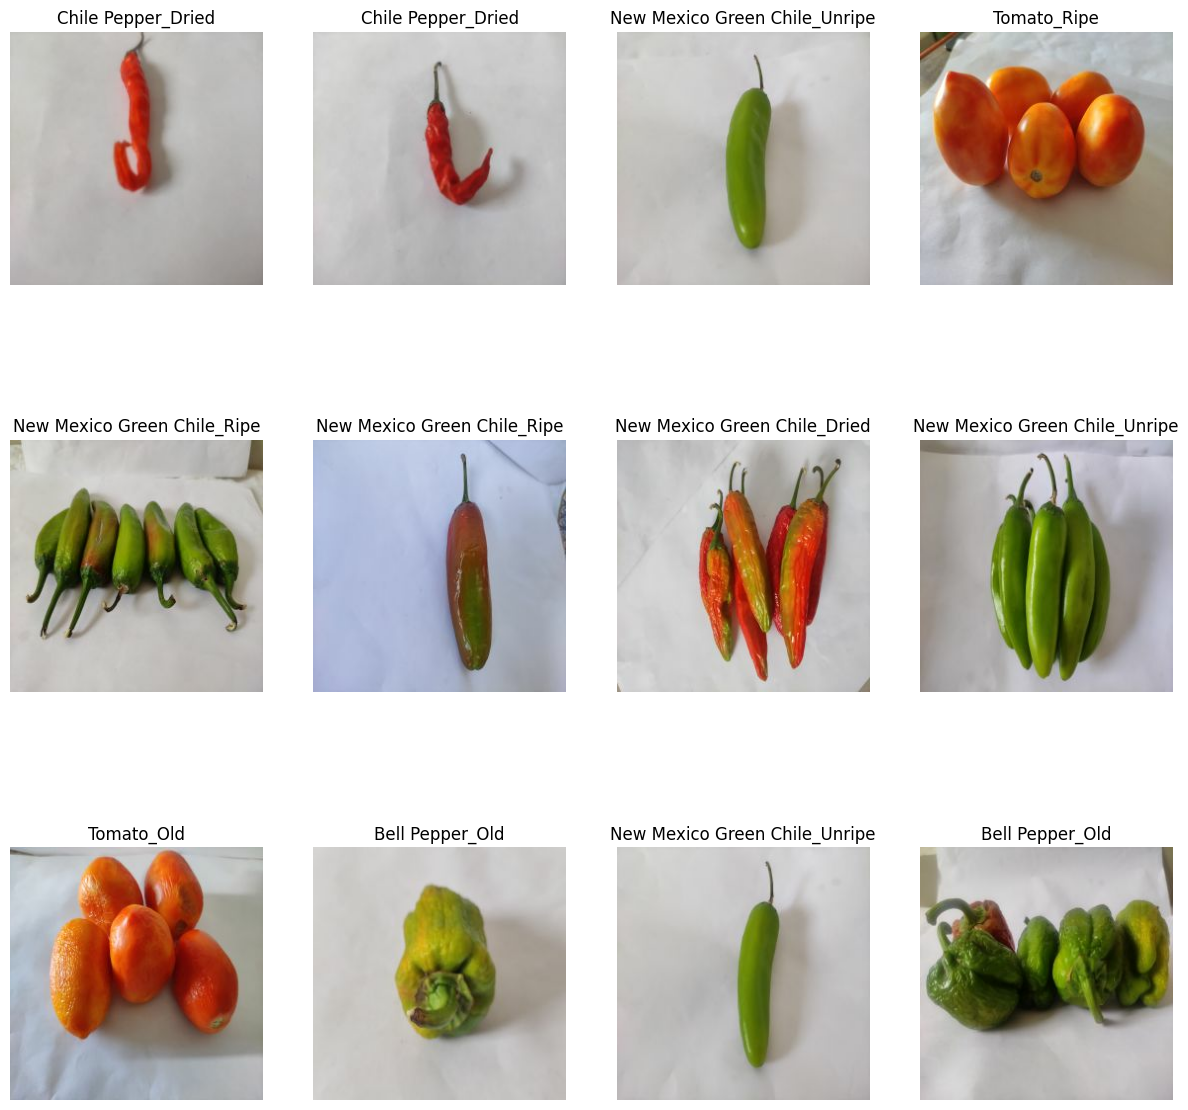

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Training

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

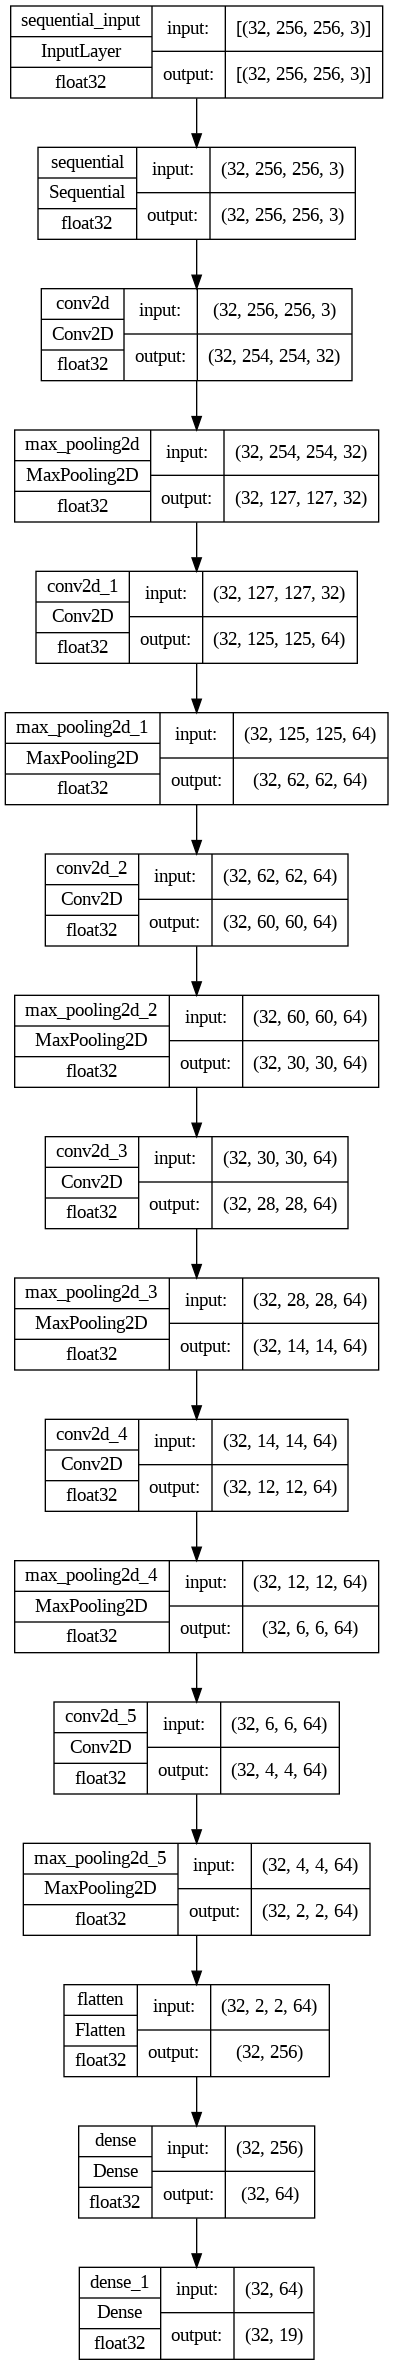

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, show_dtype=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
154/154 [==============================] - 44s 241ms/step - loss: 2.0410 - accuracy: 0.2774 - val_loss: 1.4721 - val_accuracy: 0.4326
Epoch 2/20
154/154 [==============================] - 36s 235ms/step - loss: 1.4131 - accuracy: 0.4602 - val_loss: 1.3337 - val_accuracy: 0.4753
Epoch 3/20
154/154 [==============================] - 36s 237ms/step - loss: 1.1553 - accuracy: 0.5661 - val_loss: 1.0236 - val_accuracy: 0.6382
Epoch 4/20
154/154 [==============================] - 36s 234ms/step - loss: 0.8988 - accuracy: 0.6603 - val_loss: 0.9903 - val_accuracy: 0.6447
Epoch 5/20
154/154 [==============================] - 35s 230ms/step - loss: 0.7632 - accuracy: 0.7062 - val_loss: 0.6665 - val_accuracy: 0.7533
Epoch 6/20
154/154 [==============================] - 35s 230ms/step - loss: 0.6421 - accuracy: 0.7560 - val_loss: 0.8612 - val_accuracy: 0.7089
Epoch 7/20
154/154 [==============================] - 35s 229ms/step - loss: 0.5867 - accuracy: 0.7766 - val_loss: 0.6816 - val_ac

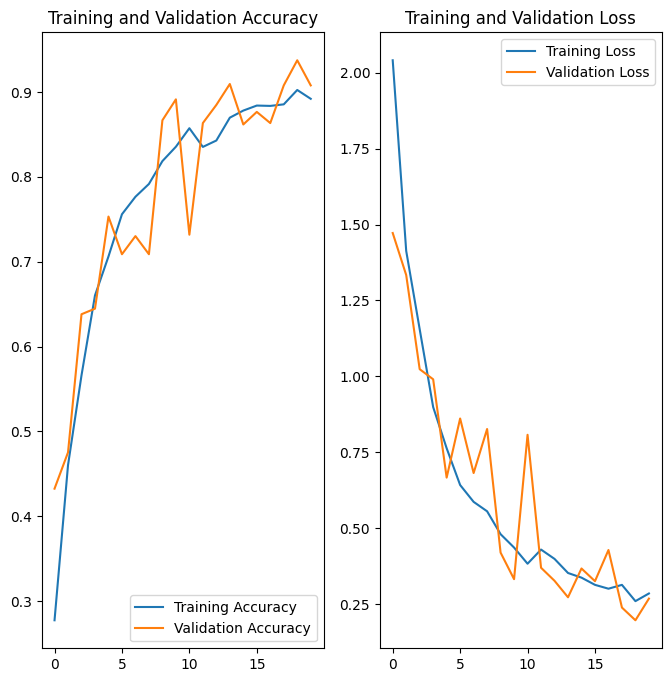

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation

In [ ]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 1s 13ms/step - loss: 0.2539 - accuracy: 0.9141


In [ ]:
scores

[0.25390297174453735, 0.9140625]

Save trained model

In [ ]:
import pickle

model_file = open('VegNet_model.pkl', 'wb')
pickle.dump(model, model_file)
model_file.close()

Load pretrained model

In [ ]:
import pickle

model_file = open('VegNet_model.pkl', 'rb')
model = pickle.load(model_file)
model_file.close()

first image to predict
actual label: Bell Pepper_Dried
1/1 [==============================] - 0s 30ms/step
predicted label: Bell Pepper_Dried


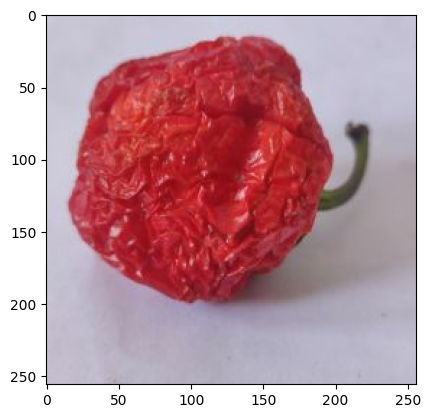

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


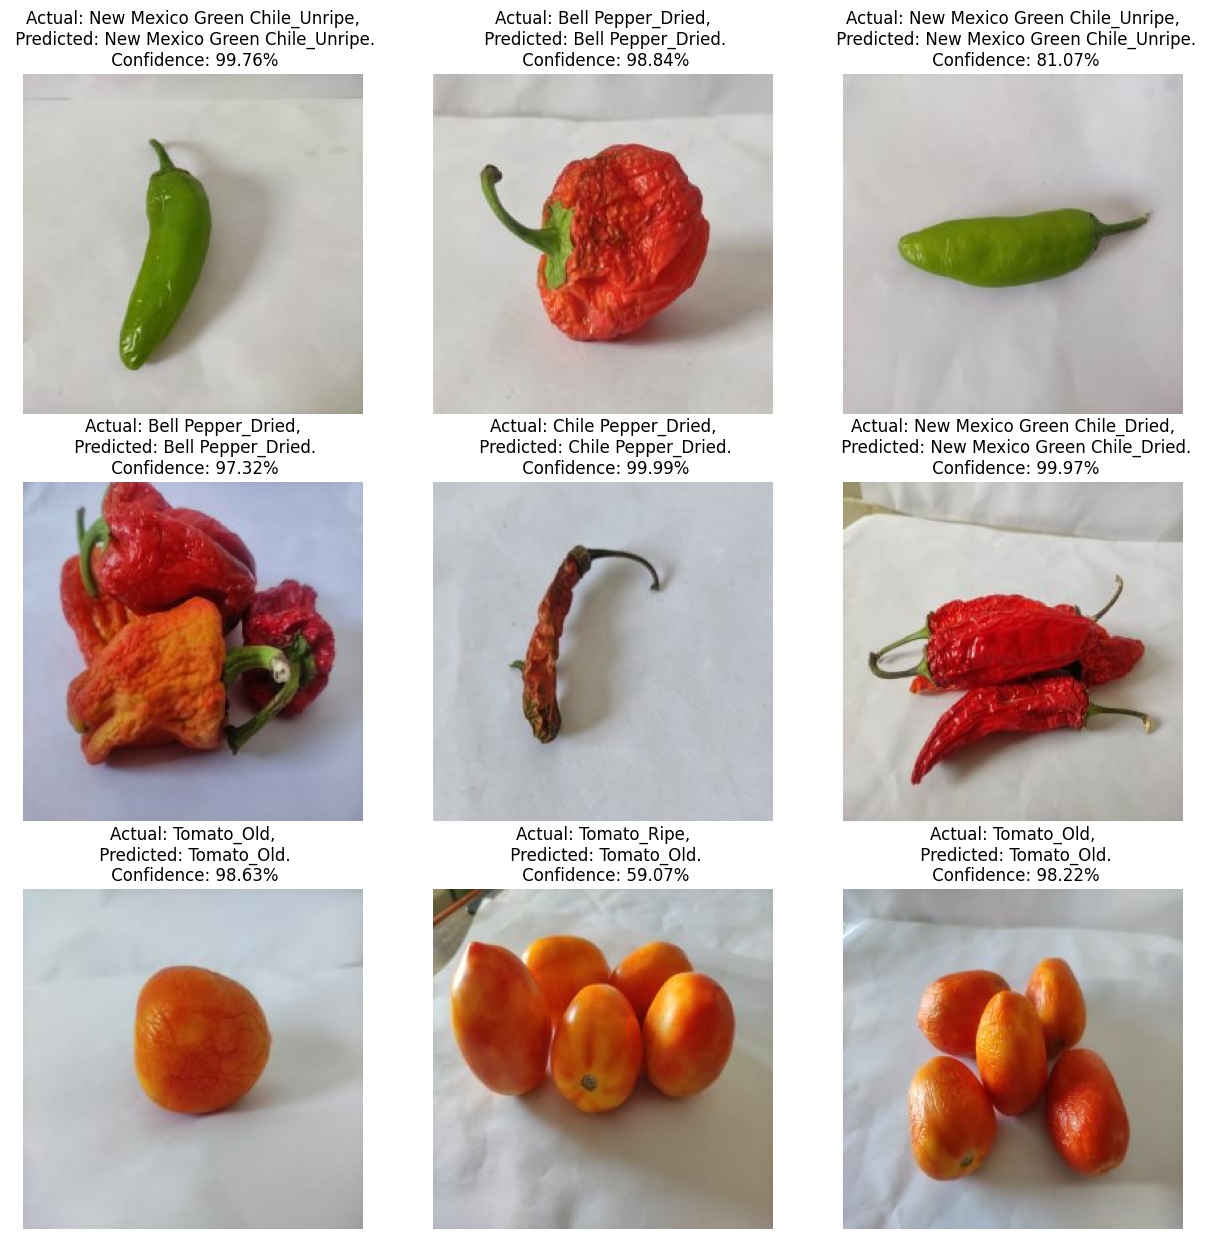

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")